In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.interpolate import interp1d
import pandas as pd



field_df = pd.read_csv('TP17 Excavation Data Cumulative A-A.csv')
field_df.iloc[:,0] =  field_df.iloc[:,0]
z_sensors= field_df.iloc[:, 0].values
wf_s4= -field_df.iloc[:,1]*1e-3 #stage 4 defelction measurements)
wf_s5= -field_df.iloc[:,4]*1e-3
wf_s6= -field_df.iloc[:,6]*1e-3
wf_s8= -field_df.iloc[:,8]*1e-3
wf_s9= -field_df.iloc[:,10]*1e-3
wf_s10 = -field_df.iloc[:,11]*1e-3

wf_s8


0    -0.000000
1     0.000234
2     0.000596
3     0.001107
4     0.001623
5     0.002165
6     0.002755
7     0.003327
8     0.003914
9     0.004509
10    0.005057
11    0.005647
12    0.006142
13    0.006553
14    0.006912
15    0.007226
16    0.007473
17    0.007679
18    0.007744
19    0.007668
20    0.007502
21    0.007241
22    0.006943
23    0.006657
24    0.006464
25    0.006306
26    0.006175
27    0.006125
28    0.005941
29    0.005887
Name: 23/09/2021, dtype: float64

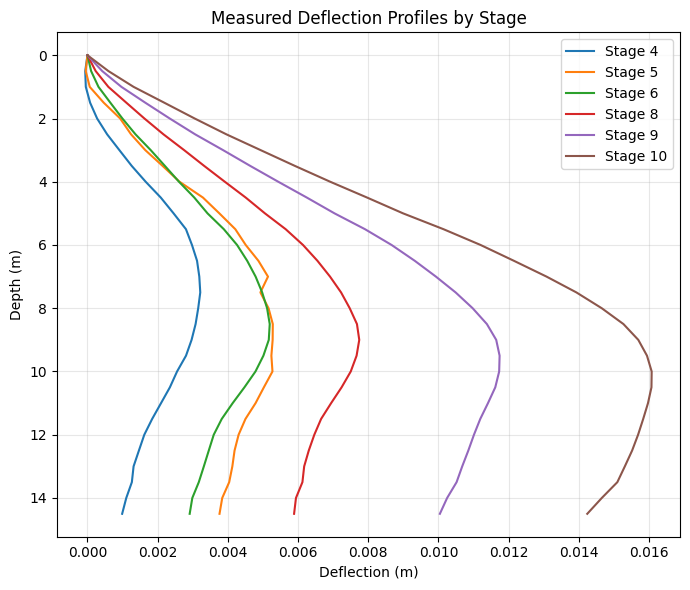

In [2]:
plt.figure(figsize=(7, 6))

plt.plot(wf_s4, z_sensors, label="Stage 4")
plt.plot(wf_s5, z_sensors, label="Stage 5")
plt.plot(wf_s6, z_sensors, label="Stage 6")
plt.plot(wf_s8, z_sensors, label="Stage 8")
plt.plot(wf_s9, z_sensors, label="Stage 9")
plt.plot(wf_s10, z_sensors, label="Stage 10")

plt.gca().invert_yaxis()  # depth increases downward
plt.xlabel("Deflection (m)")
plt.ylabel("Depth (m)")
plt.title("Measured Deflection Profiles by Stage")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

# =========================
# Block 0 — Data
# =========================
field_df = pd.read_csv('TP17 Excavation Data Cumulative A-A.csv')
z_sensors = field_df.iloc[:, 0].values
wf_s4 = -field_df.iloc[:, 8] * 1e-3  # Stage 4 deflection (m)

# =========================
# Block 1 — Model definitions & normalisation
# =========================
gama_tf_sat   = 19e3  # N/m³
gama_tf_unsat = 15e3  # N/m³
gama_go_sat   = 20e3  # N/m³
gama_go_unsat = 18e3  # N/m³
gama_water    = 9.81e3
EI = 0.58e9          # Nm2/m
L  = 14.5            # m (wall depth)
ka_tf, kp_tf = 0.5, 3.0
ka_go, kp_go = 0.5, 3.0
q_surcharge   = 20000  # N/m/m

# Sensors & normalisation
z_sensors_np = np.array(z_sensors, dtype=float)
wf_s4_np     = np.array(wf_s4,     dtype=float)

z_sensors_norm = z_sensors_np / L
w_max = np.max(np.abs(wf_s4_np));  w_max = 1.0 if w_max == 0 else w_max
w_sensors_norm = wf_s4_np / w_max

# Collocation points (↑ to 1000 for smoother w''')
z_colloc = np.linspace(0, L, 1000).reshape(-1, 1)
z_colloc_norm = z_colloc / L

z_sensors_tf_norm = tf.convert_to_tensor(z_sensors_norm.reshape(-1, 1), dtype=tf.float32)
w_sensors_tf_norm = tf.convert_to_tensor(w_sensors_norm.reshape(-1, 1), dtype=tf.float32)
z_colloc_tf_norm  = tf.convert_to_tensor(z_colloc_norm, dtype=tf.float32)

# =========================
# Block 2 — Trainable mobilisation params (UNCONSTRAINED)
# =========================
m_a_tf_ps_above = tf.Variable(0.5, dtype=tf.float32, name='m_a_tf_ps_above')
m_a_tf_ps_below = tf.Variable(0.5, dtype=tf.float32, name='m_a_tf_ps_below')
m_a_tf_above    = tf.Variable(0.5, dtype=tf.float32, name='m_a_tf_above')
m_a_tf_below   = tf.Variable(0.5, dtype=tf.float32, name='m_a_tf_below')
m_a_go    = tf.Variable(0.5, dtype=tf.float32, name='m_a_go')
m_p_tf    = tf.Variable(0.5, dtype=tf.float32, name='m_p_tf')
m_a_surcharge    = tf.Variable(0.0, dtype=tf.float32, name='m_a_surcharge')
m_p_go    = tf.Variable(0.5, dtype=tf.float32, name='m_p_go')
qp        = tf.Variable(0.5, dtype=tf.float32, name='qp')

#print("✅ Block 2 initial:",
      #float(m_a_tf_ps.numpy()), float(m_a_tf.numpy()), float(m_a_go.numpy()),
      #float(m_p_tf.numpy()), float(m_p_go.numpy()), float(qp.numpy()))

# Block 3 — q(z) builder
# =========================
q_max = 100_000.0  # N/m reference

def gaussian_prop_load(z, z_prop, P_peak, sigma):
    """Narrow Gaussian prop load with exact peak value."""
    return P_peak * tf.exp(-0.5 * ((z - z_prop) / sigma) ** 2)

def piecewise_q_normalized(z_normalised):
    z = z_normalised * L
    H_exposed = 6.3

    # --- Enforce constraints ---
    # 1. m_a_surcharge must be non-negative
    m_a_surcharge_clipped = tf.maximum(m_a_surcharge, 0.0)

    # 2. qp must be at least 0.1 (if positive) or at most -0.1 (if negative)
    qp_clipped = tf.where(qp > 0, tf.maximum(qp, 0.1), tf.minimum(qp, -0.1))

    # Effective vertical stresses (with constrained surcharge mobilisation)
    s_va1 = gama_tf_unsat * z + m_a_surcharge_clipped * q_surcharge
    s_va2 = gama_tf_unsat * 2.85 + (gama_tf_sat - gama_water) * (z - 2.85) + m_a_surcharge_clipped * q_surcharge
    s_va3 = (gama_tf_unsat * 2.85 +
             (gama_tf_sat - gama_water) * (11.8 - 2.85) +
             (gama_go_sat - gama_water) * (z - 11.8) + m_a_surcharge_clipped * q_surcharge)

    s_vp1 = gama_tf_unsat * (z - H_exposed)
    s_vp2 = gama_tf_unsat * (11.8 - H_exposed) + gama_go_unsat * (z - 11.8)
    s_vp3 = (gama_tf_unsat * (11.8 - H_exposed) +
             gama_go_unsat * (13.0 - 11.8) +
             (gama_go_sat - gama_water) * (z - 13.0))

    # Prop depths
    z_top_prop = 0.6
    z_bottom_prop = 5.8

    # Active (retained) — with separate mobilisation zones
    active_pressure = tf.where(
        z <= 2.85,
        tf.where(z <= z_top_prop,
                 s_va1 * ka_tf * m_a_tf_ps_above,
                 s_va1 * ka_tf * m_a_tf_ps_below),
        tf.where(
            z <= 11.8,
            tf.where(z <= z_bottom_prop,
                     s_va2 * ka_tf * m_a_tf_above + gama_water * (z - 2.85),
                     s_va2 * ka_tf * m_a_tf_below + gama_water * (z - 2.85)),
            s_va3 * ka_go * m_a_go + gama_water * (z - 2.85)
        )
    )

    # Passive (excavated)
    passive_pressure = tf.where(
        z < H_exposed,
        tf.zeros_like(z),
        tf.where(
            z <= 11.8,
            s_vp1 * kp_tf * m_p_tf,
            tf.where(
                z <= 13.0,
                s_vp2 * kp_go * m_p_go,
                s_vp3 * kp_go * m_p_go + gama_water * (z - 13.0)
            )
        )
    )

    total_pressure = active_pressure - passive_pressure

    # Gaussian prop load at top prop (using constrained qp)
    point_gauss_0p6 = gaussian_prop_load(z, z_top_prop, 15000.0 * qp_clipped, sigma=0.02)
    # If you want a bottom prop, uncomment below:
    point_gauss_5p8 = gaussian_prop_load(z, z_bottom_prop, 200000.0, sigma=0.02)

    total_pressure = total_pressure - point_gauss_0p6   - point_gauss_5p8

    return total_pressure / q_max  # dimensionless

# Optional anchors
w_top_obs_norm = (wf_s4_np[0]  / w_max) if len(wf_s4_np) > 0 else 0.0
w_bot_obs_norm = (wf_s4_np[-1] / w_max) if len(wf_s4_np) > 0 else 0.0
# =========================
# Block 4 — Model & derivatives (network widened to 64)
# =========================
def make_model():
    return tf.keras.Sequential([
        tf.keras.layers.Input(shape=(1,)),
        tf.keras.layers.Dense(64, activation='swish'),
        tf.keras.layers.Dense(64, activation='swish'),
        tf.keras.layers.Dense(64, activation='swish'),
        tf.keras.layers.Dense(64, activation='swish'),
        tf.keras.layers.Dense(1)
    ])
model = make_model()

def compute_derivatives(z_input):
    with tf.GradientTape(persistent=True) as t4:
        t4.watch(z_input)
        with tf.GradientTape(persistent=True) as t3:
            t3.watch(z_input)
            with tf.GradientTape(persistent=True) as t2:
                t2.watch(z_input)
                with tf.GradientTape() as t1:
                    t1.watch(z_input)
                    w_norm = model(z_input)
                dw_norm  = t1.gradient(w_norm, z_input)
            d2w_norm = t2.gradient(dw_norm, z_input)
        d3w_norm = t3.gradient(d2w_norm, z_input)
    d4w_norm = t4.gradient(d3w_norm, z_input)
    return w_norm, dw_norm, d2w_norm, d3w_norm, d4w_norm

def trapz_tf(y, x):
    return tf.reduce_sum(0.5 * (y[1:] + y[:-1]) * (x[1:] - x[:-1]))

# =========================
# Block 5 — Losses: Data + Physics + Horizontal Equilibrium
# =========================
@tf.function
def compute_losses():
    # Derivatives at collocation points (normalised z)
    w_norm, _, d2w_norm, d3w_norm, d4w_norm = compute_derivatives(z_colloc_tf_norm)

    # Base q (dimensionless)
    q_hat_norm = piecewise_q_normalized(z_colloc_tf_norm)

    # Physics (local): EI w'''' = q
    physics_residual = d4w_norm * (EI * w_max / (L**4 * q_max)) - q_hat_norm
    physics_loss = tf.reduce_mean(tf.square(physics_residual))

    # Data loss at sensor points
    w_pred_sensors, _, _, _, _ = compute_derivatives(z_sensors_tf_norm)
    data_loss = tf.reduce_mean(tf.square(w_pred_sensors - w_sensors_tf_norm))

    # Light BC anchors
    bc_loss = (tf.square(w_norm[0] - w_top_obs_norm) +
               tf.square(w_norm[-1] - w_bot_obs_norm))

    # ---------- Global horizontal force equilibrium ----------
    z_phys = (z_colloc_tf_norm[:, 0]) * L                 # m
    q_phys = (q_hat_norm[:, 0]) * q_max                   # N/m
    Vw =  (EI * w_max / (L**3)) * d3w_norm[:, 0]         # N

    H_tot = trapz_tf(q_phys, z_phys)                      # N
    r_H   = (Vw[-1] - Vw[0]) - H_tot                      # N

    eqH_loss = tf.square(r_H / q_max)
    # ---------------------------------------------------------------

    return data_loss, physics_loss, bc_loss, eqH_loss

print("✅ Block 4 complete: Derivative and loss functions defined.")

# =========================
# Block 5.1 — Training setup (physics phase: data 0.8 / phys 0.2)
# =========================
lr_schedule_model  = tf.keras.optimizers.schedules.ExponentialDecay(5e-4, 10000, 0.9)
lr_schedule_params = tf.keras.optimizers.schedules.ExponentialDecay(5e-4, 20000, 0.9)
optimizer_model  = tf.keras.optimizers.Adam(learning_rate=lr_schedule_model)
optimizer_params = tf.keras.optimizers.Adam(learning_rate=lr_schedule_params)

N_DATA_ONLY_EPOCHS = 10_000
N_PHYSICS_EPOCHS   = 20_000
N_BC_EPOCHS        = 30_000
TOTAL_EPOCHS       = 30_000

history = {k: [] for k in ["loss", "data", "phys", "bc", "eqH"]}
history_params = {k: [] for k in [
    "m_a_tf_ps_above", "m_a_tf_ps_below",
    "m_a_tf_above", "m_a_tf_below",
    "m_a_go", "m_p_tf", "m_p_go",
    "m_a_surcharge", "qp"
]}

@tf.function
def train_step(epoch_val):
    with tf.GradientTape() as tape:
        data_l, phys_l, bc_l, eqH_l = compute_losses()

        if epoch_val < N_DATA_ONLY_EPOCHS:
            w_data, w_phys, w_bc = 1.0, 0.0, 0.0
        elif epoch_val < N_PHYSICS_EPOCHS:
            w_data, w_phys, w_bc = 0.8, 0.2, 0.0
        elif epoch_val < N_BC_EPOCHS:
            w_data, w_phys, w_bc = 0.5, 0.45, 0.05
        else:
            w_data, w_phys, w_bc = 0.6, 0.35, 0.05

        w_eqH = 0.2

        total_loss = (w_data * data_l +
                      w_phys * phys_l +
                      w_bc   * bc_l +
                      w_eqH  * eqH_l)

    model_vars = model.trainable_variables
    param_vars = [
        m_a_tf_ps_above, m_a_tf_ps_below,
        m_a_tf_above, m_a_tf_below,
        m_a_go, m_p_tf, m_p_go,
        m_a_surcharge, qp
    ]

    grads = tape.gradient(total_loss, model_vars + param_vars)
    grads_model  = grads[:len(model_vars)]
    grads_params = grads[len(model_vars):]

    optimizer_model.apply_gradients(zip(grads_model, model_vars))
    optimizer_params.apply_gradients(zip(grads_params, param_vars))

    return total_loss, data_l, phys_l, bc_l, eqH_l

# =========================
# Block 5.2 — Train
# =========================
for epoch in range(TOTAL_EPOCHS):
    loss, data_l, phys_l, bc_l, eqH_l = train_step(tf.constant(epoch, dtype=tf.int32))

    history["loss"].append(float(loss.numpy()))
    history["data"].append(float(data_l.numpy()))
    history["phys"].append(float(phys_l.numpy()))
    history["bc"].append(float(bc_l.numpy()))
    history["eqH"].append(float(eqH_l.numpy()))

    history_params["m_a_tf_ps_above"].append(float(m_a_tf_ps_above.numpy()))
    history_params["m_a_tf_ps_below"].append(float(m_a_tf_ps_below.numpy()))
    history_params["m_a_tf_above"].append(float(m_a_tf_above.numpy()))
    history_params["m_a_tf_below"].append(float(m_a_tf_below.numpy()))
    history_params["m_a_go"].append(float(m_a_go.numpy()))
    history_params["m_p_tf"].append(float(m_p_tf.numpy()))
    history_params["m_p_go"].append(float(m_p_go.numpy()))
    history_params["m_a_surcharge"].append(float(m_a_surcharge.numpy()))
    history_params["qp"].append(float(qp.numpy()))

    if epoch % 1000 == 0 or epoch in [N_DATA_ONLY_EPOCHS, N_PHYSICS_EPOCHS, N_BC_EPOCHS, TOTAL_EPOCHS - 1]:
        print(f"Epoch {epoch:5d} | Total: {history['loss'][-1]:.3e} | Data: {history['data'][-1]:.3e} "
              f"| Phys: {history['phys'][-1]:.3e} | BC: {history['bc'][-1]:.3e} | EqH: {history['eqH'][-1]:.3e}")

print("✅ Training finished.")

✅ Block 4 complete: Derivative and loss functions defined.


<ipython-input-3-abf78f3a826f>:276: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  history["loss"].append(float(loss.numpy()))
<ipython-input-3-abf78f3a826f>:279: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  history["bc"].append(float(bc_l.numpy()))


Epoch     0 | Total: 1.182e+00 | Data: 5.254e-01 | Phys: 7.577e-02 | BC: 5.590e-01 | EqH: 3.282e+00
Epoch  1000 | Total: 2.206e-03 | Data: 2.204e-03 | Phys: 1.114e-01 | BC: 1.610e-02 | EqH: 8.419e-06
Epoch  2000 | Total: 1.605e-03 | Data: 1.603e-03 | Phys: 1.029e-01 | BC: 1.224e-02 | EqH: 8.497e-06
Epoch  3000 | Total: 8.752e-05 | Data: 8.747e-05 | Phys: 8.502e-02 | BC: 3.060e-04 | EqH: 2.404e-07
Epoch  4000 | Total: 2.005e-04 | Data: 2.004e-04 | Phys: 9.104e-02 | BC: 1.132e-03 | EqH: 4.916e-07
Epoch  5000 | Total: 6.214e-05 | Data: 6.214e-05 | Phys: 9.145e-02 | BC: 2.219e-04 | EqH: 1.065e-10
Epoch  6000 | Total: 6.163e-05 | Data: 6.163e-05 | Phys: 9.164e-02 | BC: 2.358e-04 | EqH: 1.271e-11
Epoch  7000 | Total: 6.123e-05 | Data: 6.123e-05 | Phys: 9.147e-02 | BC: 2.423e-04 | EqH: 1.399e-10
Epoch  8000 | Total: 6.083e-05 | Data: 6.083e-05 | Phys: 9.113e-02 | BC: 2.467e-04 | EqH: 2.330e-10
Epoch  9000 | Total: 6.033e-05 | Data: 6.033e-05 | Phys: 9.078e-02 | BC: 2.359e-04 | EqH: 1.816e-12



=== Horizontal force equilibrium ===
V(L)-V(0) = -1.493e+05 N,   ∫q dz =  1.493e+05 N,   residual = -3.500e+00 N
Residual ratio = 2.414e-06


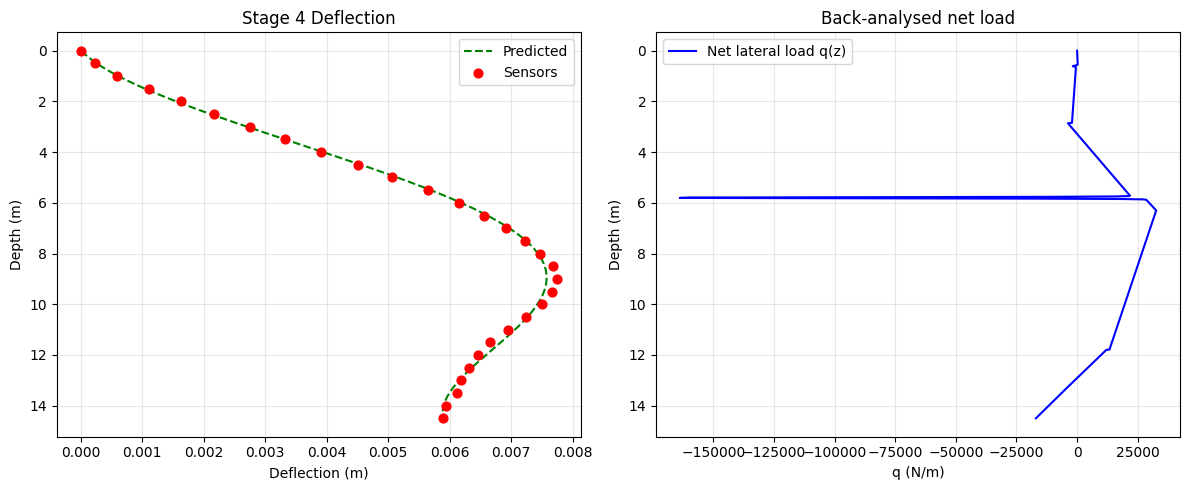

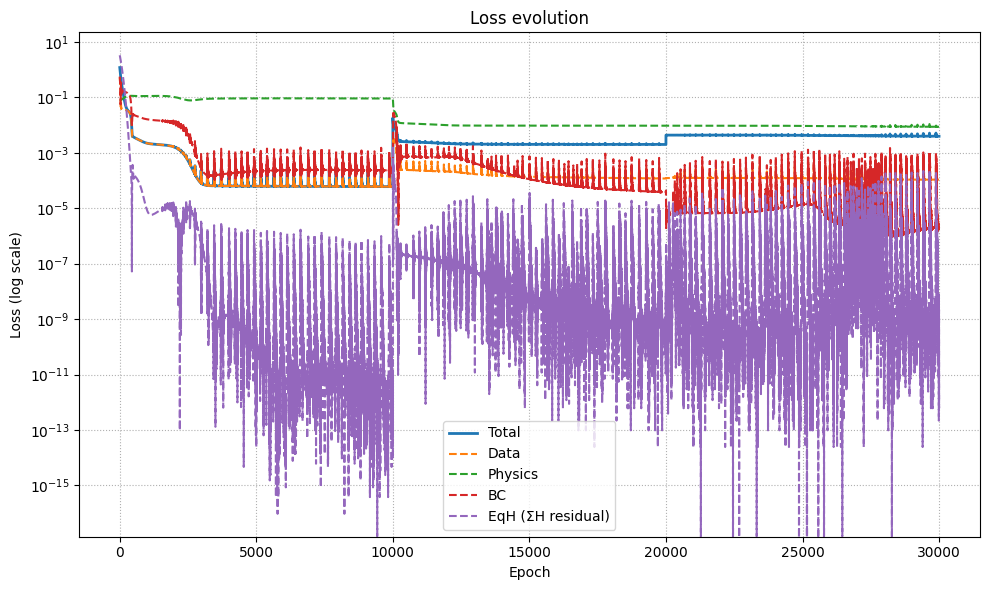

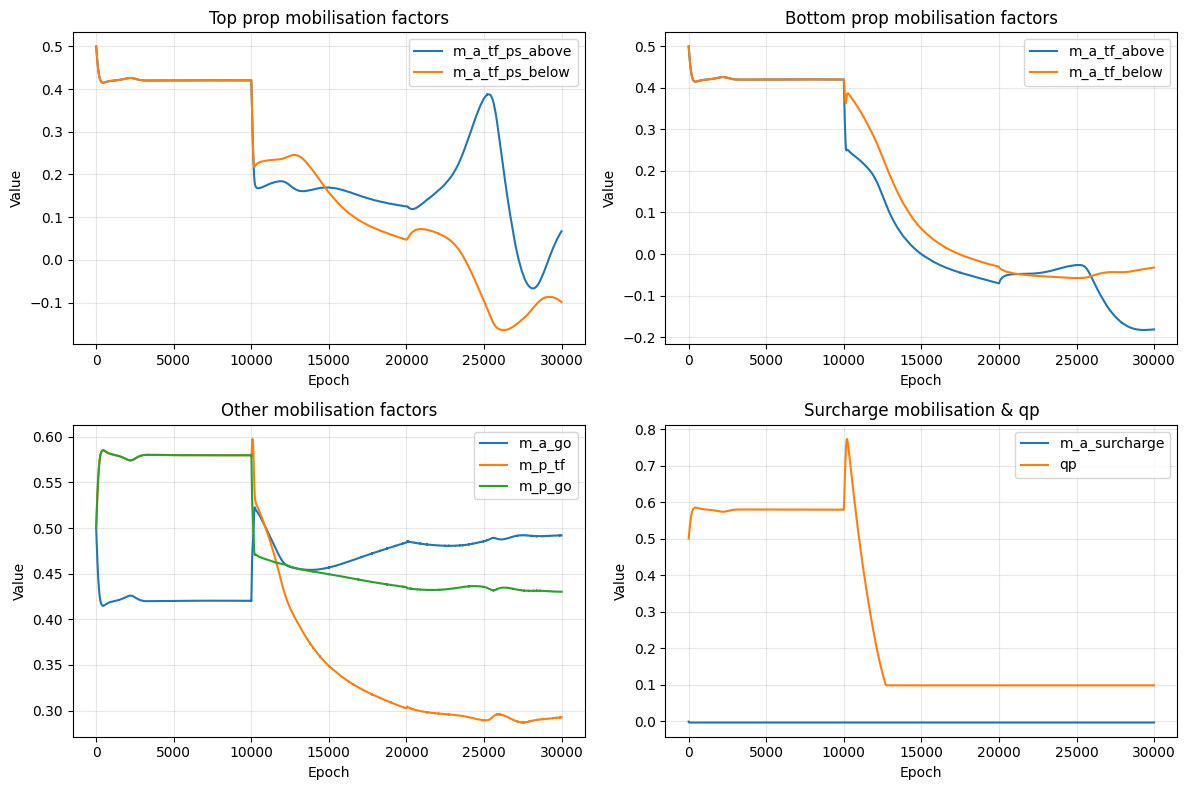


=== Final trained parameters ===
m_a_tf_ps_above: 0.067
m_a_tf_ps_below: -0.099
m_a_tf_above:    -0.181
m_a_tf_below:    -0.032
m_a_go:          0.492
m_p_tf:          0.293
m_p_go:          0.430
m_a_surcharge:   -0.003
qp:              0.099


In [4]:
# =========================
# Block 6 — Post-Training: predictions, plots, ΣH report
# =========================
# Deflection & derivatives
w_norm, dw_norm, d2w_norm, d3w_norm, d4w_norm = compute_derivatives(z_colloc_tf_norm)
z_physical    = z_colloc_tf_norm.numpy().flatten() * L
w_pred_unnorm = (w_norm.numpy().flatten()) * w_max

# q(z)
q_pred_norm   = piecewise_q_normalized(z_colloc_tf_norm).numpy().flatten()
q_pred_unnorm = q_pred_norm * q_max

# ΣH report using end shear and ∫q
Vw = - (EI * w_max / (L**3)) * d3w_norm.numpy().flatten()
H_tot = np.trapz(q_pred_unnorm, z_physical)
r_H   = (Vw[-1] - Vw[0]) + H_tot
print("\n=== Horizontal force equilibrium ===")
print(f"V(L)-V(0) = {Vw[-1]-Vw[0]: .3e} N,   ∫q dz = {H_tot: .3e} N,   residual = {r_H: .3e} N")
print(f"Residual ratio = {abs(r_H)/(q_max*L + 1.0):.3e}")

# --------------------
# 1. Deflection plot
# --------------------
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(w_pred_unnorm, z_physical, label='Predicted', linestyle='--', color='green')
plt.scatter(wf_s4_np, z_sensors_np, s=40, label='Sensors', color='red', zorder=3)
plt.gca().invert_yaxis()
plt.xlabel('Deflection (m)'); plt.ylabel('Depth (m)')
plt.title('Stage 4 Deflection')
plt.legend(); plt.grid(True, alpha=0.3)

# --------------------
# 2. Inferred load plot
# --------------------
plt.subplot(1, 2, 2)
plt.plot(q_pred_unnorm, z_physical, label='Net lateral load q(z)', color='blue')
plt.gca().invert_yaxis()
plt.xlabel('q (N/m)'); plt.ylabel('Depth (m)')
plt.title('Back-analysed net load')
plt.legend(); plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------
# 3. Training loss evolution
# --------------------
epochs = np.arange(TOTAL_EPOCHS)
plt.figure(figsize=(10, 6))
plt.plot(epochs, history["loss"], label="Total", linewidth=2)
plt.plot(epochs, history["data"], label="Data", linestyle="--")
plt.plot(epochs, history["phys"], label="Physics", linestyle="--")
plt.plot(epochs, history["bc"],   label="BC", linestyle="--")
plt.plot(epochs, history["eqH"],  label="EqH (ΣH residual)", linestyle="--")
plt.yscale('log'); plt.xlabel("Epoch"); plt.ylabel("Loss (log scale)")
plt.title("Loss evolution")
plt.legend(); plt.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

# --------------------
# 4. Mobilisation & qp evolution
# --------------------
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(epochs, history_params["m_a_tf_ps_above"], label="m_a_tf_ps_above")
plt.plot(epochs, history_params["m_a_tf_ps_below"], label="m_a_tf_ps_below")
plt.xlabel("Epoch"); plt.ylabel("Value")
plt.title("Top prop mobilisation factors")
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(epochs, history_params["m_a_tf_above"], label="m_a_tf_above")
plt.plot(epochs, history_params["m_a_tf_below"], label="m_a_tf_below")
plt.xlabel("Epoch"); plt.ylabel("Value")
plt.title("Bottom prop mobilisation factors")
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(epochs, history_params["m_a_go"], label="m_a_go")
plt.plot(epochs, history_params["m_p_tf"], label="m_p_tf")
plt.plot(epochs, history_params["m_p_go"], label="m_p_go")
plt.xlabel("Epoch"); plt.ylabel("Value")
plt.title("Other mobilisation factors")
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(epochs, history_params["m_a_surcharge"], label="m_a_surcharge")
plt.plot(epochs, history_params["qp"], label="qp")
plt.xlabel("Epoch"); plt.ylabel("Value")
plt.title("Surcharge mobilisation & qp")
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --------------------
# Final trained parameters
# --------------------
print("\n=== Final trained parameters ===")
print(f"m_a_tf_ps_above: {m_a_tf_ps_above.numpy():.3f}")
print(f"m_a_tf_ps_below: {m_a_tf_ps_below.numpy():.3f}")
print(f"m_a_tf_above:    {m_a_tf_above.numpy():.3f}")
print(f"m_a_tf_below:    {m_a_tf_below.numpy():.3f}")
print(f"m_a_go:          {m_a_go.numpy():.3f}")
print(f"m_p_tf:          {m_p_tf.numpy():.3f}")
print(f"m_p_go:          {m_p_go.numpy():.3f}")
print(f"m_a_surcharge:   {m_a_surcharge.numpy():.3f}")
print(f"qp:              {qp.numpy():.3f}")


In [5]:
# =========================
# Block 7 — Export q(z) + parameters to CSV
# =========================

# Ensure q(z) and z are computed
# (If Block 6 ran just before, these should already be available)
# Otherwise uncomment the lines below:
# q_pred_norm   = piecewise_q_normalized(z_colloc_tf_norm).numpy().flatten()
# q_pred_unnorm = q_pred_norm * q_max
# z_physical    = z_colloc_tf_norm.numpy().flatten() * L

# Use the same H_exposed as in piecewise_q_normalized
H_exposed_value = 8

# Build a DataFrame with one row per depth; parameters repeated for each row
export_df = pd.DataFrame({
    "depth_m": z_physical,                     # 0..L
    "q_N_per_m": q_pred_unnorm,                 # physical q(z)
    "H_exposed_m": H_exposed_value,
    "m_a_tf_ps_above": float(m_a_tf_ps_above.numpy()),
    "m_a_tf_ps_below": float(m_a_tf_ps_below.numpy()),
    "m_a_tf_above":    float(m_a_tf_above.numpy()),
    "m_a_tf_below":    float(m_a_tf_below.numpy()),
    "m_a_go":          float(m_a_go.numpy()),
    "m_p_tf":          float(m_p_tf.numpy()),
    "m_p_go":          float(m_p_go.numpy()),
    "m_a_surcharge":   float(m_a_surcharge.numpy()),
    "qp":              float(qp.numpy()),
    # Optional context fields (handy later)
    "ka_tf": ka_tf, "kp_tf": kp_tf,
    "ka_go": ka_go, "kp_go": kp_go,
    "gamma_tf_sat_Npm3":   gama_tf_sat,
    "gamma_tf_unsat_Npm3": gama_tf_unsat,
    "gamma_go_sat_Npm3":   gama_go_sat,
    "gamma_go_unsat_Npm3": gama_go_unsat,
    "gamma_water_Npm3":    gama_water,
    "EI_Nm2_per_m": EI,
    "L_m": L,
    "q_max_Npm": q_max
})

# Save to CSV
export_filename = "q_stage8_8.0_190825.csv"  # Change stageX to actual stage ID
export_df.to_csv(export_filename, index=False)
print(f"✅ Exported depth vs q(z) and parameters to {export_filename} (rows: {len(export_df)})")


✅ Exported depth vs q(z) and parameters to q_stage8_8.0_190825.csv (rows: 1000)


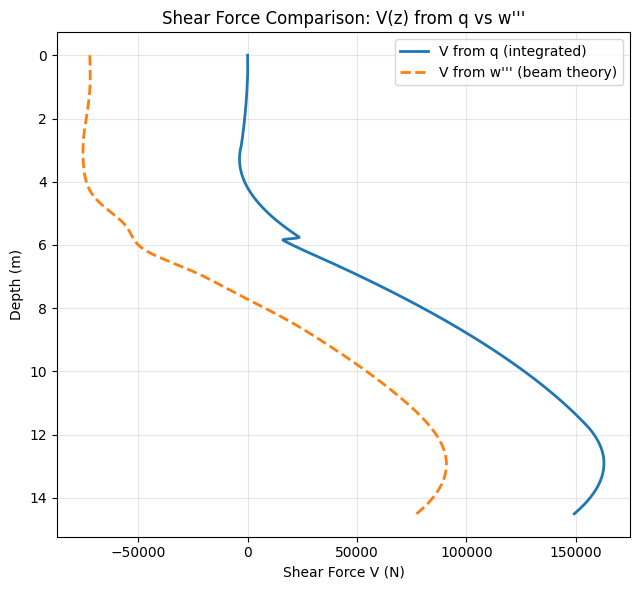

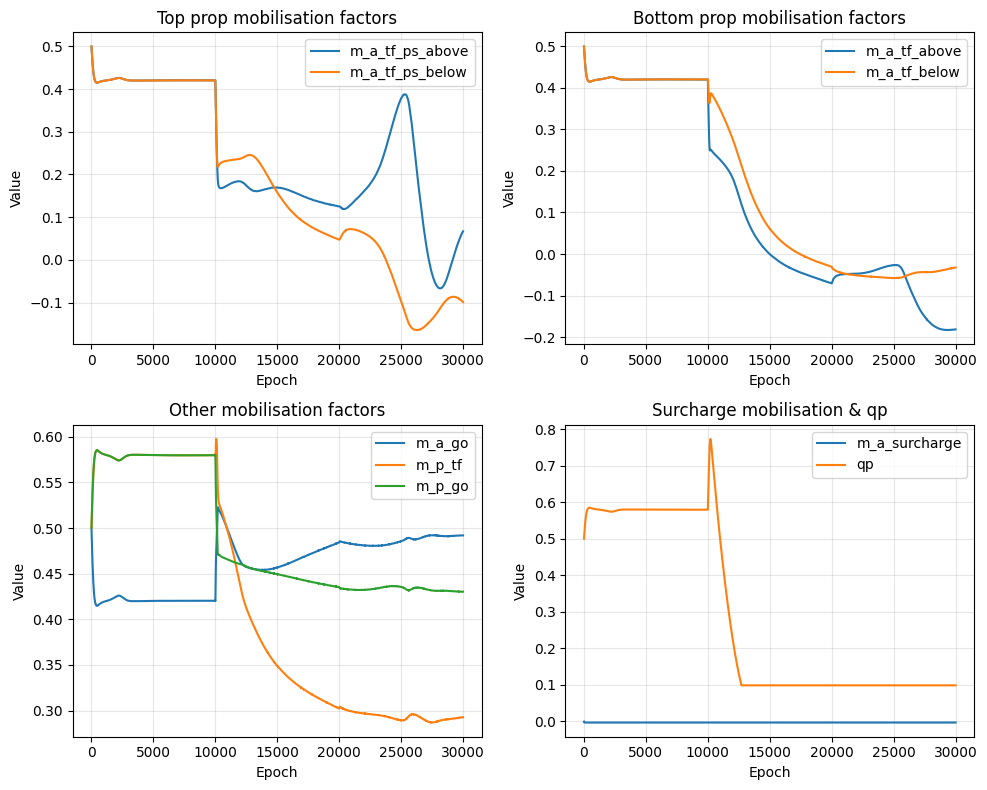

In [6]:
# =========================
# Shear comparison (actual reactions, no flipping/alignment)
# =========================
# Build shear from q(z) via integration (positive downwards if q is positive downwards)
Vq = np.zeros_like(q_pred_unnorm)
Vq[1:] = np.cumsum(0.5 * (q_pred_unnorm[1:] + q_pred_unnorm[:-1]) * np.diff(z_physical))

# Shear from w''' using beam theory (no sign flip or offset alignment)
Vw_raw = (EI * w_max / (L**3)) * d3w_norm.numpy().flatten()

# Plot directly
plt.figure(figsize=(6.5, 6))
plt.plot(Vq, z_physical, label='V from q (integrated)', linewidth=2)
plt.plot(Vw_raw, z_physical, '--', label='V from w\'\'\' (beam theory)', linewidth=2)
plt.gca().invert_yaxis()
plt.xlabel('Shear Force V (N)')
plt.ylabel('Depth (m)')
plt.title('Shear Force Comparison: V(z) from q vs w\'\'\'')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =========================
# Mobilisation parameter evolution (new parameter set)
# =========================
epochs = np.arange(len(history_params["m_a_tf_ps_above"]))

plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, history_params["m_a_tf_ps_above"], label="m_a_tf_ps_above")
plt.plot(epochs, history_params["m_a_tf_ps_below"], label="m_a_tf_ps_below")
plt.xlabel("Epoch"); plt.ylabel("Value")
plt.title("Top prop mobilisation factors")
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(epochs, history_params["m_a_tf_above"], label="m_a_tf_above")
plt.plot(epochs, history_params["m_a_tf_below"], label="m_a_tf_below")
plt.xlabel("Epoch"); plt.ylabel("Value")
plt.title("Bottom prop mobilisation factors")
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(epochs, history_params["m_a_go"], label="m_a_go")
plt.plot(epochs, history_params["m_p_tf"], label="m_p_tf")
plt.plot(epochs, history_params["m_p_go"], label="m_p_go")
plt.xlabel("Epoch"); plt.ylabel("Value")
plt.title("Other mobilisation factors")
plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
plt.plot(epochs, history_params["m_a_surcharge"], label="m_a_surcharge")
plt.plot(epochs, history_params["qp"], label="qp")
plt.xlabel("Epoch"); plt.ylabel("Value")
plt.title("Surcharge mobilisation & qp")
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
